In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles, make_gaussian_quantiles,make_classification

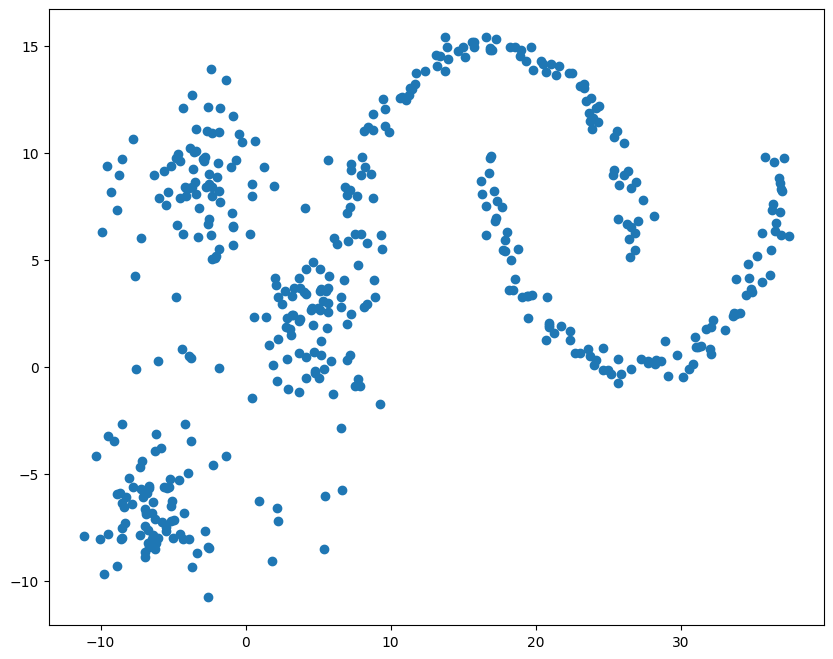

In [ ]:
data_blobs, labels_blobs = make_blobs(n_samples=200, centers=3, random_state=42, cluster_std=2)
data_moons, labels_moons = make_moons(n_samples = 200, noise=0.05, random_state=4)
# data_circles, labels_circles = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=42)
# data_quantiles, labels_quantiles = make_gaussian_quantiles(n_samples=300, n_features=2, n_classes=3, random_state=42)

data_complex = np.vstack([data_blobs, 10 * data_moons + [17, 5]])
labels_complex = np.concatenate([labels_blobs, labels_moons + 3])

np.random.seed(42)

outliers = np.random.uniform(low=-10, high=10, size=(50, 2))
data_complex = np.vstack([data_complex, outliers])
labels_complex = np.concatenate([labels_complex, np.ones(50) * 9])

shuffle_idx = np.random.permutation(len(data_complex))
data = data_complex[shuffle_idx]
labels_complex = labels_complex[shuffle_idx]

plt.figure(figsize = (10,8))
plt.scatter(data[:,0], data[:,1])
plt.show()

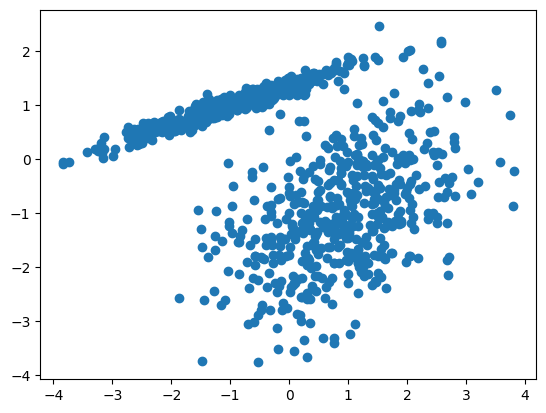

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=14)
plt.scatter(X[:,0], X[:,1])

In [ ]:
def get_gaussian_similarity_matrix(data, sigma):

  num_samples = len(data)
  similarity_matrix = np.zeros((num_samples, num_samples))

  for i in range(num_samples):
      for j in range(num_samples):
          score = np.exp(-np.linalg.norm((data[i] - data[j])**2)/(2*sigma**2))
          similarity_matrix[i,j] = score
          similarity_matrix[j,i] = score

  return similarity_matrix

In [ ]:
def g_spectral_clustering(data,n_clusters, sigma= 1.0, threshold = 0.5):

  similarity_matrix = get_gaussian_similarity_matrix(data, sigma)

  adjacency_matrix = (similarity_matrix > threshold).astype(float)

  diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
  laplacian_matrix = diagonal_matrix - adjacency_matrix

  eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
  indices = np.argsort(eigenvalues)[:n_clusters]
  normalized_matrix = eigenvectors[:, indices]
  # k_eigenvectors[np.isnan(k_eigenvectors)] = 0

  # row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  # normalized_matrix = k_eigenvectors / row_norms[:, np.newaxis]

  # row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  # # Handle potential division by very small numbers or zeros
  # normalized_matrix = np.where(row_norms < 1e-10, 0, k_eigenvectors / row_norms[:, np.newaxis])


  kmeans = KMeans(n_clusters=n_clusters, n_init=3)
  kmeans.fit(normalized_matrix)
  labels = kmeans.labels_

  return labels

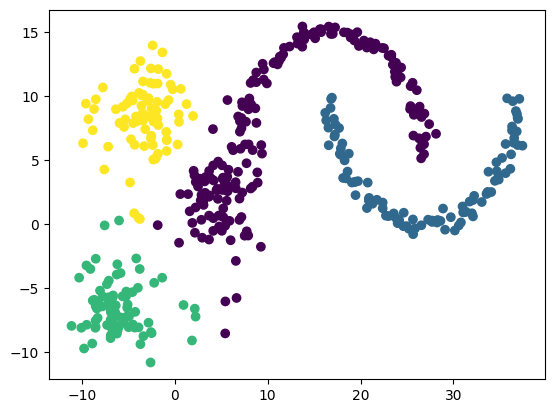

In [ ]:
labels = g_spectral_clustering(data = data,n_clusters = 4, sigma= 1.7, threshold = 0.19)
plt.scatter(data[:,0], data[:,1], c = labels)

In [ ]:
from sklearn.neighbors import kneighbors_graph

In [ ]:
def knn_similarity_matrix(data, k_neighbors=5):
    # Compute KNN graph
    knn_graph = kneighbors_graph(data, n_neighbors=k_neighbors, mode='connectivity', include_self=False)
    # Convert to dense matrix
    similarity_matrix = knn_graph.toarray()
    return similarity_matrix

def knn_spectral_clustering(data,n_clusters, k_neighbors=5 , threshold = 0.5):

  similarity_matrix = knn_similarity_matrix(data, k_neighbors)

  adjacency_matrix = (similarity_matrix > threshold).astype(float)

  diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
  laplacian_matrix = diagonal_matrix - adjacency_matrix

  eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
  indices = np.argsort(eigenvalues)[:n_clusters]
  k_eigenvectors = eigenvectors[:, indices]
  # k_eigenvectors[np.isnan(k_eigenvectors)] = 0

  row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  normalized_matrix = k_eigenvectors / row_norms[:, np.newaxis]

  normalized_matrix[np.isnan(normalized_matrix)] = 0
  normalized_matrix[np.isinf(normalized_matrix)] = 0

  # row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  # # Handle potential division by very small numbers or zeros
  # normalized_matrix = np.where(row_norms < 1e-10, 0, k_eigenvectors / row_norms[:, np.newaxis])


  kmeans = KMeans(n_clusters=n_clusters, n_init=3)
  kmeans.fit(normalized_matrix)
  labels = kmeans.labels_

  return labels

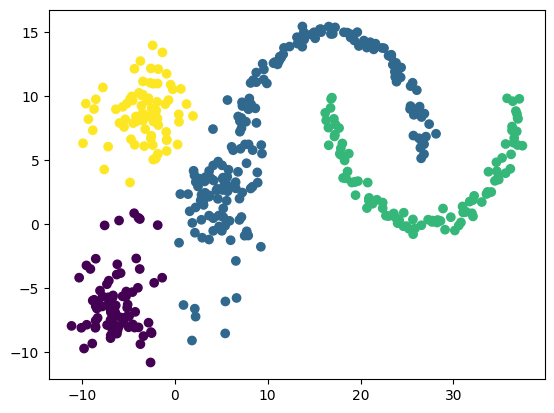

In [ ]:
labels = knn_spectral_clustering(data = data,n_clusters = 4, k_neighbors=16, threshold = 0.5)
plt.scatter(data[:,0], data[:,1], c = labels)

In [ ]:
labels = knn_spectral_clustering(data = X,n_clusters = 2, k_neighbors=50, threshold = 0.5)
plt.scatter(X[:,0], X[:,1], c = labels)

In [ ]:
from sklearn.neighbors import NearestNeighbors

def mutual_knn_similarity_matrix(data, k_neighbors=5):
    # Compute mutual KNN graph
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Create adjacency matrix for mutual KNN
    mutual_adjacency_matrix = np.zeros((len(data), len(data)))

    for i in range(len(data)):
        for j in indices[i][1:]:
            if i in indices[j][1:]:
                mutual_adjacency_matrix[i, j] = 1
                mutual_adjacency_matrix[j, i] = 1

    return mutual_adjacency_matrix

def mutual_spectral_clustering(data,n_clusters, k_neighbors=5 , threshold = 0.5):

  similarity_matrix = mutual_knn_similarity_matrix(data, k_neighbors)

  adjacency_matrix = (similarity_matrix > threshold).astype(float)

  diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
  laplacian_matrix = diagonal_matrix - adjacency_matrix

  eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
  indices = np.argsort(eigenvalues)[:n_clusters]
  k_eigenvectors = eigenvectors[:, indices]
  # k_eigenvectors[np.isnan(k_eigenvectors)] = 0

  row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  normalized_matrix = k_eigenvectors / row_norms[:, np.newaxis]

  normalized_matrix[np.isnan(normalized_matrix)] = 0
  normalized_matrix[np.isinf(normalized_matrix)] = 0

  kmeans = KMeans(n_clusters=n_clusters, n_init=3)
  kmeans.fit(normalized_matrix)
  labels = kmeans.labels_

  return labels

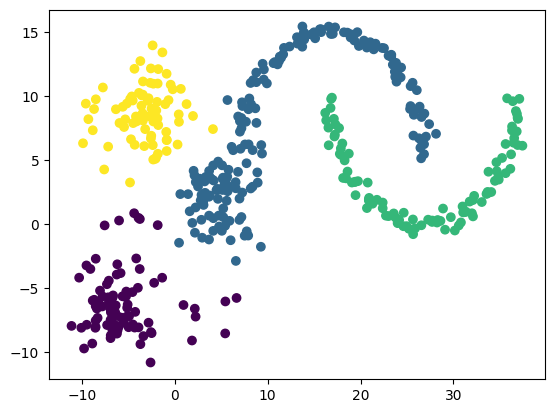

In [ ]:
labels = mutual_spectral_clustering(data = data,n_clusters = 4, k_neighbors=15, threshold = 0.5)
plt.scatter(data[:,0], data[:,1], c = labels)

In [ ]:
# Mutual knn spectral clustering with normalized laplacian

from sklearn.neighbors import NearestNeighbors

def mutual_knn_similarity_matrix(data, k_neighbors=5):
    # Compute mutual KNN graph
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Create adjacency matrix for mutual KNN
    mutual_adjacency_matrix = np.zeros((len(data), len(data)))

    for i in range(len(data)):
        for j in indices[i][1:]:
            if i in indices[j][1:]:
                mutual_adjacency_matrix[i, j] = 1
                mutual_adjacency_matrix[j, i] = 1

    return mutual_adjacency_matrix

def mutual_spectral_clustering(data,n_clusters, k_neighbors=5 , threshold = 0.5):

  similarity_matrix = mutual_knn_similarity_matrix(data, k_neighbors)

  adjacency_matrix = (similarity_matrix > threshold).astype(float)

  diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
  laplacian_matrix = diagonal_matrix - adjacency_matrix
  normalized_laplacian = np.linalg.inv(np.sqrt(diagonal_matrix)) @ laplacian_matrix @ np.linalg.inv(np.sqrt(diagonal_matrix))


  eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)
  indices = np.argsort(eigenvalues)[:n_clusters]
  k_eigenvectors = eigenvectors[:, indices]
  # k_eigenvectors[np.isnan(k_eigenvectors)] = 0

  row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  normalized_matrix = k_eigenvectors / row_norms[:, np.newaxis]

  normalized_matrix[np.isnan(normalized_matrix)] = 0
  normalized_matrix[np.isinf(normalized_matrix)] = 0

  kmeans = KMeans(n_clusters=n_clusters, n_init=3)
  kmeans.fit(normalized_matrix)
  labels = kmeans.labels_

  return labels

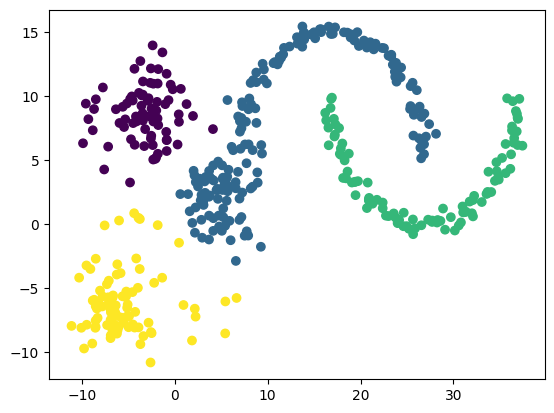

In [ ]:
labels = mutual_spectral_clustering(data = data,n_clusters = 4, k_neighbors=15, threshold = 0.5)
plt.scatter(data[:,0], data[:,1], c = labels)

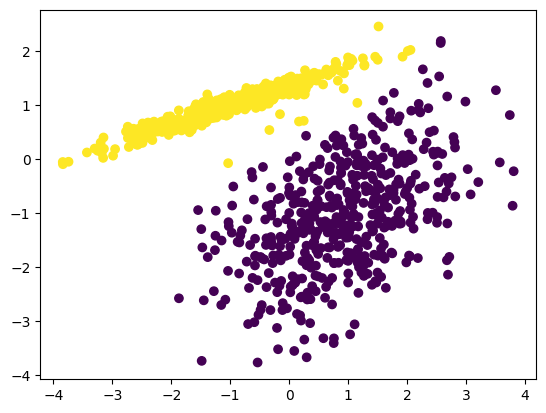

In [ ]:
def epsilon_similarity_matrix(data, epsilon):
    distance_matrix = np.linalg.norm(data[:, np.newaxis, :] - data, axis=-1)
    similarity_matrix = (distance_matrix <= epsilon).astype(float)
    return similarity_matrix

def epsilon_spectral_clustering(data,n_clusters, epsilon , threshold = 0.5):

  similarity_matrix = epsilon_similarity_matrix(data, epsilon)

  adjacency_matrix = (similarity_matrix > threshold).astype(float)

  diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=1))
  laplacian_matrix = diagonal_matrix - adjacency_matrix
  normalized_laplacian = np.linalg.inv(np.sqrt(diagonal_matrix)) @ laplacian_matrix @ np.linalg.inv(np.sqrt(diagonal_matrix))

  eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)
  indices = np.argsort(eigenvalues)[:n_clusters]
  k_eigenvectors = eigenvectors[:, indices]
  # k_eigenvectors[np.isnan(k_eigenvectors)] = 0

  row_norms = np.linalg.norm(k_eigenvectors, axis=1, ord=2)
  normalized_matrix = k_eigenvectors / row_norms[:, np.newaxis]

  normalized_matrix[np.isnan(normalized_matrix)] = 0
  normalized_matrix[np.isinf(normalized_matrix)] = 0

  kmeans = KMeans(n_clusters=n_clusters, n_init=3)
  kmeans.fit(normalized_matrix)
  labels = kmeans.labels_

  return labels

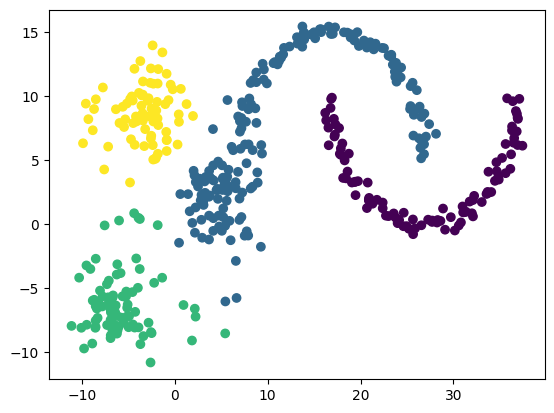

In [ ]:
labels = epsilon_spectral_clustering(data = data,n_clusters = 4, epsilon=4, threshold = 0.5)
plt.scatter(data[:,0], data[:,1], c = labels)

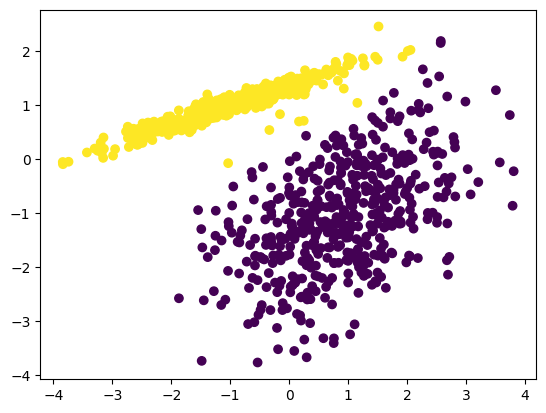

In [ ]:
labels = epsilon_spectral_clustering(data = X,n_clusters = 2, epsilon=1, threshold = 0.5)
plt.scatter(X[:,0], X[:,1], c = labels)

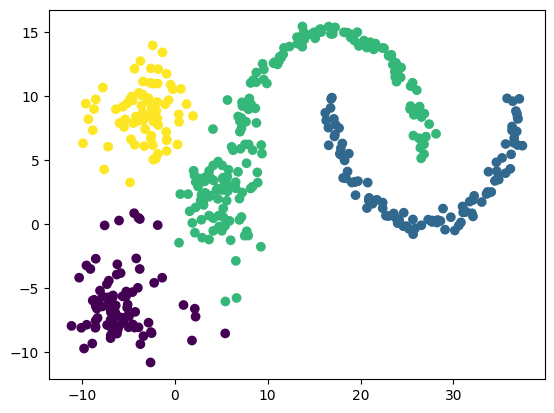

In [ ]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=4, affinity='rbf',gamma=0.19)
labels = spectral_clustering.fit_predict(data)

plt.scatter(data[:,0], data[:,1], c = labels)

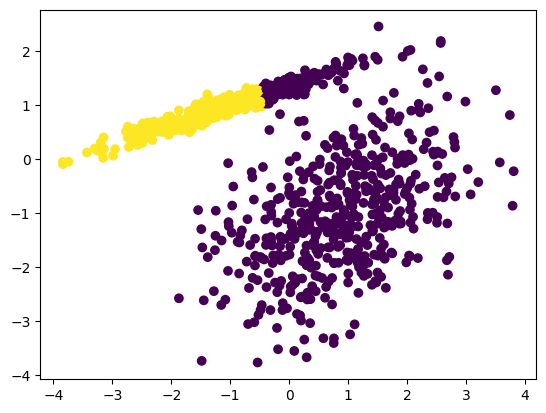

In [ ]:
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',n_neighbors=20)
labels = spectral_clustering.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c = labels)